### Wasserstein GAN (weight-clipping version)

* GAN-training: as per Arjovsky et al. (2017), with the simplest possible setup.
* Architecture:
    * Discriminator: two CNN layers, two FC layers, outputs logits.
    * Generator: four-layered DeConv Net.
* Comments:
    * Regularizer and RMSProp are also frequently used. C-cliping is an important technique in training WGAN, but gosh it's hard to tune.
    * Weight-clipping method's usually phased out in favor for gradient penalty.
    * **NB: the setup here is incredibly hard to tune, the stuff almost always produce crap. But see the improved version in gradient penalty.**

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

### Prepare data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Image count: 55000 | Image pixel size: 784
Image sample:


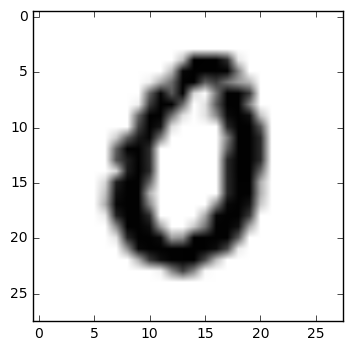

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
x_train = mnist.train.images[:55000,:]
print("Image count: {} | Image pixel size: {}".format(*x_train.shape))
print("Image sample:")
plt.imshow(x_train[random.randint(0,len(x_train))].reshape([28,28]),
           cmap='gray_r')
plt.show()

### CNN

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, 
                        strides=[1,1,1,1], padding='SAME')

def avg_pool2d(x):
    return tf.nn.avg_pool(x, ksize=[1,2,2,1], 
                          strides=[1,2,2,1], padding='SAME')
        # ksize: <batch,height,width,channels>

### Discriminator

In [4]:
class D:
    
    def __init__(self):
        self.name = 'discriminator'
    
    def __call__(self, x, keep_prob=1.0, reuse=False):
        # x: <batch,height,width,in-channels>
        with tf.variable_scope(self.name) as scope:
            if reuse:
                scope.reuse_variables()
            # Conv-avgpool 1
            W_conv1 = tf.get_variable('d_wconv1', [5,5,1,8], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.02))
                # shape: <filter-height/batch,filter-width/num-pixels,in-channels,out-channels>
                #   in-channels = input #channels, usually set to 1.
                #   out-channels = output #channels, however many params you want.
            b_conv1 = tf.get_variable('d_bconv1', [8], 
                                      initializer=tf.constant_initializer(0))
            h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1) 
                # <batch,height,width,out-chn> = <?,28,28,8> (NB: 'SAME' conv)
            h_pool1 = tf.nn.dropout(avg_pool2d(h_conv1),keep_prob)
                # <batch,height,width,out-chn> = <?,14,14,8>
                #   2x2 maxpooling, reducing height & width by half.
            # Conv-avgpool 2
            W_conv2 = tf.get_variable('d_wconv2', [5,5,8,16], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.02))
            b_conv2 = tf.get_variable('d_bconv2', [16], 
                                      initializer=tf.constant_initializer(0))
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
                # <batch,height,width,out-chn> = <?,14,14,16>
            h_pool2 = tf.nn.dropout(avg_pool2d(h_conv2),keep_prob)
                # <batch,height,width,out-chn> = <?,7,7,16>
            # FC-1
            W_fc1 = tf.get_variable('d_wfc1', [7*7*16,32], 
                                    initializer=tf.truncated_normal_initializer(stddev=0.02))
                # <height*width*out-chn,hid-fc1=32>
            b_fc1 = tf.get_variable('d_bfc1', [32], 
                                    initializer=tf.constant_initializer(0))
            h_pool2_flat = tf.reshape(h_pool2, [-1,7*7*16])
                # <batch,height,width,out-chn> -> <batch,height*width*out-chn>
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
                # affine: <batch,height*width*out-chn> * <height*width*out-chn,hid-fc1=32> = <batch,hid-fc1=32>
            # FC-2
            W_fc2 = tf.get_variable('d_wfc2', [32,1], 
                                    initializer=tf.truncated_normal_initializer(stddev=0.02))
                # <hid-fc1=32,hid-fc2=1>
            b_fc2 = tf.get_variable('d_bfc2', [1], 
                                    initializer=tf.constant_initializer(0))
            y_conv= tf.add(tf.matmul(h_fc1, W_fc2), b_fc2)
                # affine: <batch,hid-fc1=32> * <hid-fc1=32,hid-fc2=1> = <batch,1>
                # NB: no softmax transformation, operating with logits.
        return y_conv
    
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

### Generator

In [5]:
class G:
    
    def __init__(self):
        self.name = 'generator'
    
    def __call__(self, z, batch_size, z_dim, keep_prob=1.0, reuse=False):
        # z: random noise input: <batch,z-dim>
        # batch-size,z-dim: explicitly put for debugging,
        #   but can be extracted at runtime with tf.unstack(tf.reshape(z)).
        with tf.variable_scope(self.name) as scope:
            if reuse:
                scope.reuse_variables()
            g_dim = 64 # num-filters of first layer of generator 
            c_dim = 1  # Color dimension of output (MNIST is grayscale, so c_dim = 1)
            s = 28     # Output size of the image
            s2, s4, s8, s16 = s//2, s//4, s//8, s//16 
                # Exponential image upscaling
                #   ^1 -> ^4 for gradual transition.
            h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
                # h0: <batch,height=2,width=2,in-chn=25>
                #   s16=28//16 = 1
            h0 = tf.nn.relu(h0)
            # DeConv-1
            output1_shape = [batch_size,s8,s8,g_dim*4]
                # out-shape: <batch,height=3,width=3,out-chn=64*4>
                #   s8=28//8 = 3
            W_conv1 = tf.get_variable('g_wconv1', [5,5,output1_shape[-1],int(h0.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
                # shape: <filter-height/batch,filter-width/num-pixels,out-channels,in-channels>
                #   NB: for deconv, in & out-channels switch place.
            b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv1
            H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, 
                                                   is_training=True, scope="g_bn1")
                # center,scale: (input-beta)/gamma
                #   beta,gamma initialized as mean and std.
            H_conv1 = tf.nn.dropout(tf.nn.relu(H_conv1),keep_prob)
                # <batch,height=3,width=3,out-chn=256>
            # DeConv-2
            output2_shape = [batch_size,s4-1,s4-1,g_dim*2]
                # out-shape: <batch,height=6,width=6,out-chn=64*2>
                #   s4=28//4 = 7
            W_conv2 = tf.get_variable('g_wconv2', [5,5,output2_shape[-1],int(H_conv1.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv2
            H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, 
                                                   is_training=True, scope="g_bn2")
            H_conv2 = tf.nn.dropout(tf.nn.relu(H_conv2),keep_prob)
                # <batch,height=6,width=6,out-chn=128>
            # DeConv-3
            output3_shape = [batch_size,s2-2,s2-2,g_dim*1]
                # out-shape: <batch,height=12,width=12,out-chn=64*1>
                #   s2=28//2 = 14
            W_conv3 = tf.get_variable('g_wconv3', [5,5,output3_shape[-1],int(H_conv2.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv3
            H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, 
                                                   is_training=True, scope="g_bn3")
            H_conv3 = tf.nn.dropout(tf.nn.relu(H_conv3),keep_prob)
                # <batch,height=12,width=12,out-chn=64>
            # DeConv-final
            output4_shape = [batch_size,s,s,c_dim]
                # out-shape: <batch,height=28,width=28,out-chn=1>
                #   s=28
                #   original data shape restored now.
            W_conv4 = tf.get_variable('g_wconv4', [5,5,output4_shape[-1],int(H_conv3.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
            H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                             strides=[1,2,2,1], padding='VALID') + b_conv4
            H_conv4 = tf.nn.dropout(tf.nn.tanh(H_conv4),keep_prob)
                # <batch,height=28,width=28,out-chn=1>
        return H_conv4 
    
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

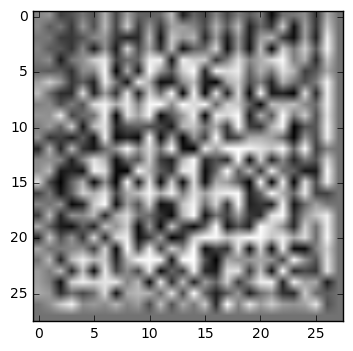

In [6]:
# Results from generator prior to training

tf.reset_default_graph()
sess = tf.Session()

z_dimensions = 100 # 100D random noise.
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
g_net = G()
sample_image = g_net(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z})) 
    # <batch-size=1,height=28,width=28,chn=1>
my_i = temp.squeeze() # get rid of all dim-1's. -> <28,28>
plt.imshow(my_i, cmap='gray_r')
plt.show()

### Wasserstein GAN (original, with weight-clipping)

In [7]:
# Build graph

tf.reset_default_graph()

sess = tf.Session()

BATCH_SIZE = 32

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1]) # input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])   # input noise vectors to the generator

d_net = D()
g_net = G()

Dx = d_net(x_placeholder) 
    # <batch,1>
    #   predicted (unscale) probabilities for the real images (i.e. logits).
Gz = g_net(z_placeholder, BATCH_SIZE, z_dimensions) 
    # <batch,height=28,width=28,chn=1>
    #   the generated images.
Dg = d_net(Gz, reuse=True) # i.e. D(Gz)
    # <batch,1>
    #   discriminator prediction probabilities for generated images.
# >> Dx, Gz, Dg
# (<tf.Tensor 'discriminator/Add:0' shape=(?, 1) dtype=float32>,
#  <tf.Tensor 'generator/Tanh:0' shape=(16, 28, 28, 1) dtype=float32>,
#  <tf.Tensor 'discriminator_1/Add:0' shape=(16, 1) dtype=float32>)

# Approximating the Earth Mover (EM) distance
d_loss = tf.reduce_mean(Dx) - tf.reduce_mean(Dg)
g_loss = tf.reduce_mean(Dg)

# # Regularization (optional, usually better w/o when dataset's simple)
# reg = tf.contrib.layers.apply_regularization(
#     tf.contrib.layers.l1_regularizer(1e-5),
#     weights_list=[var for var in tf.global_variables()]
# )
# d_loss_reg = d_loss + reg
# g_loss_reg = g_loss + reg

d_clip = [v.assign(tf.clip_by_value(v,-0.01,0.01)) for v in d_net.vars]

# Create optimizers for D & G
adam = tf.train.AdamOptimizer(2e-4)
trainer_D = adam.minimize(d_loss, var_list=d_net.vars)
trainer_G = adam.minimize(g_loss, var_list=g_net.vars)

sess.run(tf.global_variables_initializer())

In [2]:
# Training
#   D-G alternation set to 1-1
#   i.e. one update of D or G and switch.

NUM_EPOCH = 1
NUM_ITERS = 30
D_ITERS = 5
VERBOSE = 1

try:
    for e in range(NUM_EPOCH):
        print("Epoch {}:\n".format(e+1))
        d_loss_track, g_loss_track = [],[]
        for i in range(NUM_ITERS):
            sub_d_loss_track = []
            for di in range(D_ITERS):
                z_batch = np.random.normal(-1, 1, size=[BATCH_SIZE, z_dimensions])
                real_image_batch = np.reshape(mnist.train.next_batch(BATCH_SIZE)[0],
                                              [BATCH_SIZE,28,28,1])
                sess.run(d_clip)
                _,d_loss_ = sess.run([trainer_D, d_loss],feed_dict={z_placeholder:z_batch,
                                                                   x_placeholder:real_image_batch}) 
                sub_d_loss_track.append(d_loss_)
            z_batch = np.random.normal(-1, 1, size=[BATCH_SIZE, z_dimensions])
            _,g_loss_ = sess.run([trainer_G, g_loss],feed_dict={z_placeholder:z_batch}) 
            d_loss_track.append(np.mean(sub_d_loss_track))
            g_loss_track.append(g_loss_)
            if (i+1)%VERBOSE==0:
                print("Loss at step {}: D-loss = {} | G-loss = {}".format(i+1,d_loss_,g_loss_))
        print("\nEpoch average: D-loss = {} | G-loss = {}\n".format(np.mean(d_loss_track),
                                                                    np.mean(g_loss_track)))
except KeyboardInterrupt:
    print("Stopped!")

In [1]:
# Results from generator after training
sample_image = g_net(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
print("Image sample:")
plt.imshow(my_i, cmap='gray_r')
plt.show()